In [1]:
import glob
import os.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import nibabel as nib
import seaborn as sns
from visualization.display_image import display_image
import nibabel as nib
from nibabel.orientations import aff2axcodes


def get_image(in_path, mask=False):
    path = '../data/original'
    if mask:
        path += '/masks/'
    else:
        path += '/images/'

    path += f'{in_path}.nii.gz'
    image = nib.load(path)
    return image.get_fdata()

% matplotlib inline

def plot_center_sagittal_slice(source, name, data):
    data = np.transpose(data, axes=(1, 0, 2))
    center_sagittal_index = data.shape[1] // 2
    center_sagittal_slice = data[:, center_sagittal_index, :]

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    im = ax.imshow(np.rot90(center_sagittal_slice), cmap='gray', aspect='equal',
                   extent=[0, data.shape[0], 0, data.shape[0]])
    ax.set_title(f'{name} Center Sagittal (slice {center_sagittal_index})')
    ax.axis('off')
    plt.savefig(f'sagittal/{source}/{name}.png')
    plt.close()


def plot_center_sagittal_slice_with_mask(image, mask, source, name):
    data = np.transpose(image, axes=(1, 0, 2))

    # Find sagittal slice with maximum number of nonzero values in the mask
    mask_data = np.transpose(mask, axes=(1, 0, 2))
    mask_sums = np.sum(mask_data, axis=(0, 2))
    center_sagittal_index = np.argmax(mask_sums)

    center_sagittal_slice = data[:, center_sagittal_index, :]

    # Find center sagittal slice of the mask
    mask_center_sagittal_slice = mask_data[:, center_sagittal_index, :]

    # Create overlay array with non-zero values only
    overlay = np.zeros_like(center_sagittal_slice)
    overlay[mask_center_sagittal_slice != 0] = mask_center_sagittal_slice[mask_center_sagittal_slice != 0]

    # Overlay the overlay array on top of the center sagittal slice of the image
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    im = ax.imshow(np.rot90(center_sagittal_slice), cmap='gray', aspect='equal',
                   extent=[0, data.shape[0], 0, data.shape[0]])
    ax.imshow(np.rot90(overlay), cmap='Reds', alpha=0.2, aspect='equal', extent=[0, data.shape[0], 0, data.shape[0]])
    ax.set_title(f'Sagittal Slice {center_sagittal_index}')
    ax.axis('off')
    plt.savefig(f'sagittal_with_mask_cropped/{source}/{name}.png')
    plt.close()

UsageError: Line magic function `%` not found.


### Load data

In [164]:
image_paths = glob.glob('../data/original/images/*CT.nii.gz')
mask_paths = glob.glob('../data/original/masks/*.nii.gz')
data = []

lens = []

for image_path, mask_path in tqdm(zip(image_paths, mask_paths)):
    image = nib.load(image_path)
    # if image.shape[2] < 300:
    #     continue

    group = image_path.split('images\\')[1].split('-')[0]
    data.append({'source': group, 'slices': image.shape[2], 'image': image_path.split('images\\')[1].split('.')[0],
                 'mask': mask_path.split('masks\\')[1].split('.')[0]})

data = pd.DataFrame(data)
data

524it [00:00, 803.57it/s]


,source,slices,image,mask
0,CHUM,91,CHUM-001__CT,CHUM-001
1,CHUM,91,CHUM-002__CT,CHUM-002
2,CHUM,240,CHUM-006__CT,CHUM-006
3,CHUM,247,CHUM-007__CT,CHUM-007
4,CHUM,236,CHUM-008__CT,CHUM-008
...,...,...,...,...
519,MDA,127,MDA-197__CT,MDA-197
520,MDA,127,MDA-198__CT,MDA-198
521,MDA,127,MDA-199__CT,MDA-199
522,MDA,267,MDA-200__CT,MDA-200


### Number of images per source

In [154]:
data.source.value_counts()

MDA     198
CHUP     72
CHUS     72
CHUM     56
HGJ      55
CHUV     53
HMR      18
Name: source, dtype: int64

### Slice distribution all sources

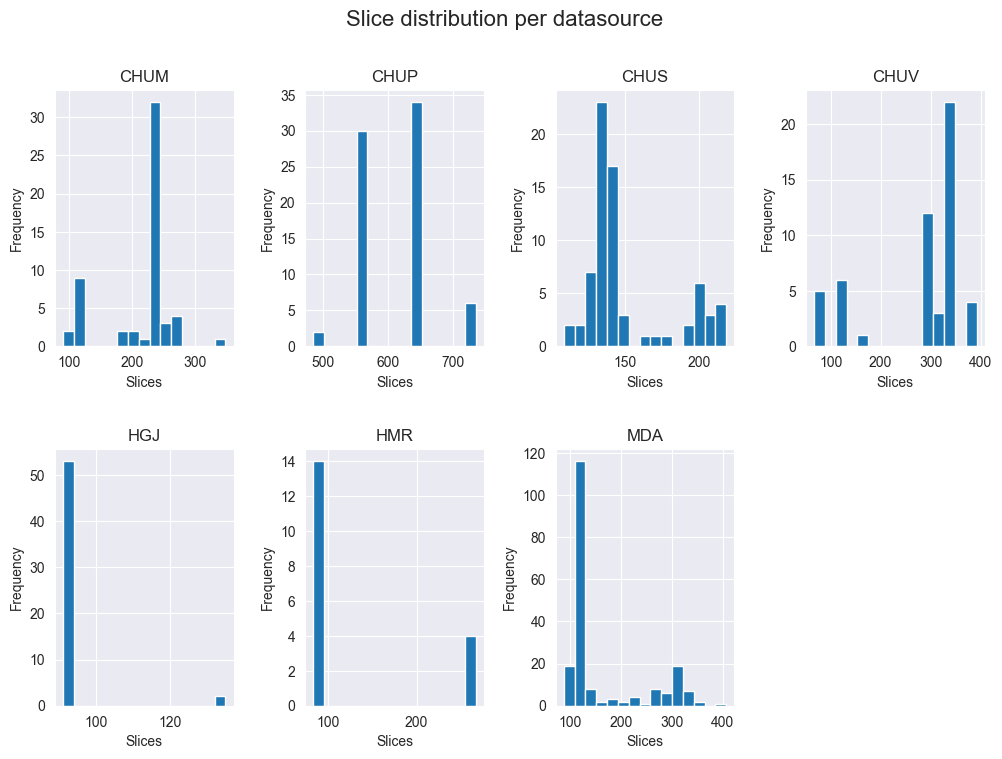

In [153]:

unique_groups = data['source'].unique()
n_groups = len(unique_groups)

# Set the figure size and style
# plt.style.use('seaborn-whitegrid')

# Create a grid of subplots with 2 columns
n_columns = 4
n_rows = int(np.ceil(n_groups / n_columns))
fig, axes = plt.subplots(n_rows, n_columns, figsize=(12, 4 * n_rows))

for i, group in enumerate(unique_groups):
    # Get the current subplot's row and column index
    row_idx = i // n_columns
    col_idx = i % n_columns

    # Plot the histogram for the current group
    axes[row_idx, col_idx].hist(data[data['source'] == group]['slices'], bins=15)

    # Set the title for the current subplot
    axes[row_idx, col_idx].set_title(group)

    # Set the x and y labels for the current subplot
    axes[row_idx, col_idx].set_xlabel('Slices')
    axes[row_idx, col_idx].set_ylabel('Frequency')

# Remove empty subplots if any
if n_groups % n_columns != 0:
    for j in range(n_groups, n_rows * n_columns):
        fig.delaxes(axes[j // n_columns, j % n_columns])

plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Add a main title for the entire plot
plt.suptitle('Slice distribution per datasource', fontsize=16)
plt.savefig('slice_distribution_separate.png')


In [155]:


# Load the Nifti image
img = nib.load('../data/original/images/CHUM-001__CT.nii.gz')

# Get the affine matrix of the image
affine = img.affine

# Get the orientation of the image axes
codes = aff2axcodes(affine)

print(codes)
# Find the index of the sagittal axis in the orientation codes
sagittal_index = codes.index('L')
print(sagittal_index)

('L', 'P', 'S')
0


### Sagittal slices

Plot sagittal slices both with and without mask

In [157]:
for idx, source in enumerate(data['source'].unique()):
    s = data[data['source'] == source]
    if not os.path.exists(f'sagittal/{source}'):
        os.mkdir(f'sagittal/{source}')

    if not os.path.exists(f'sagittal_with_mask/{source}'):
        os.mkdir(f'sagittal_with_mask/{source}')

    print(f'[{idx}/{len(data["source"].unique())}] {source} [{len(s)}]')
    for image, mask in tqdm(zip(s['image'].values, s['mask'].values)):
        image_data = get_image(image, mask=False)
        mask_data = get_image(mask, mask=True)

        if mask_data.shape[0] != image_data.shape[0]:
            mask_data = mask_data[:image_data.shape[0], :, :]

        if mask_data.shape[1] != image_data.shape[1]:
            mask_data = mask_data[:, :image_data.shape[1], :]

        if mask_data.shape[2] != image_data.shape[2]:
            mask_data = mask_data[:, :, :image_data.shape[2]]

        # plot_center_sagittal_slice(image_data, source, image)
        # plot_center_sagittal_slice_with_mask(image_data, mask_data, source, image)

[4/7] HGJ [55]


55it [01:51,  2.02s/it]


[5/7] HMR [18]


18it [00:32,  1.82s/it]


[6/7] MDA [198]


198it [07:03,  2.14s/it]


After this, images are cropped. See slice.py for how this is done and specific croppings for specific sources. Next step is to visualize the cropped images with masks.

In [176]:
image_paths = glob.glob('../data/cropped/images/*CT.nii.gz')
mask_paths = glob.glob('../data/cropped/masks/*.nii.gz')

for image, mask in tqdm(zip(image_paths, mask_paths)):
    image_data = nib.load(image).get_fdata()
    mask_data = nib.load(mask).get_fdata()

    if mask_data.shape[0] != image_data.shape[0]:
        mask_data = mask_data[:image_data.shape[0], :, :]

    if mask_data.shape[1] != image_data.shape[1]:
        mask_data = mask_data[:, :image_data.shape[1], :]

    if mask_data.shape[2] != image_data.shape[2]:
        mask_data = mask_data[:, :, :image_data.shape[2]]

    source = (image.split('images\\')[1].split('-')[0])

    if not os.path.exists(f'sagittal_with_mask_cropped/{source}'):
        os.mkdir(f'sagittal_with_mask_cropped/{source}')
    # plot_center_sagittal_slice(image_data, source, image)
    plot_center_sagittal_slice_with_mask(image_data, mask_data, source, image.split('images\\')[1].split('.')[0])



160it [04:43,  1.77s/it]


Now to create a new dataset with the cropped images and the original images. Cropped images should be moved and original images should be copied

In [2]:
images_to_crop = {
    'CHUM': [
        '013',
        '035',
        '040',
        '065',
    ],
    'CHUP': 'all',
    'CHUS': ['101'],
    'CHUV':
        ['002',
         '003',
         '004',
         '005',
         '006',
         '007',
         '008',
         '009',
         '010',
         '011',
         '022',
         '023',
         '024',
         '025',
         '026',
         '027',
         '028',
         '029',
         '031',
         '032',
         '034',
         '035',
         '038',
         '040',
         '041'
         '043',
         '044',
         '045',
         '046',
         '049',
         '050',
         '051',
         '052'],
    'HMR': [
        '001',
        '012',
        '013',
        '028',
    ],
    'MDA':
        [
            '001',
            '003',
            '004',
            '005',
            '006',
            '007',
            '029',
            '030',
            '032',
            '036',
            '048',
            '052',
            '055',
            '056',
            '057',
            '059',
            '063',
            '067',
            '072',
            '074',
            '075',
            '086',
            '087',
            '092',
            '097',
            '101',
            '102',
            '103',
            '108',
            '109',
            '111',
            '117',
            '120',
            '122',
            '123',
            '144',
            '153',
            '157',
            '161',
            '163',
            '164',
            '170',
            '175',
            '178',
            '188',
            '190',
            '194',
            '200'
        ]
}

cropped_images = glob.glob('../data/cropped/images/*.nii.gz')
cropped_masks = glob.glob('../data/cropped/masks/*.nii.gz')

original_images = glob.glob('../data/original/images/*.nii.gz')
original_masks = glob.glob('../data/original/masks/*.nii.gz')


In [ ]:
import os
import shutil

# Define the paths of the new folders
new_images_folder = '../data/cropped_original'
new_masks_folder = '../data/cropped_original'

if not os.path.exists(new_images_folder):
    os.mkdir(new_images_folder)

if not os.path.exists(new_masks_folder):
    os.mkdir(new_masks_folder)

if not os.path.exists(f'{new_images_folder}/images'):
    os.mkdir(f'{new_images_folder}/images')

if not os.path.exists(f'{new_masks_folder}/masks'):
    os.mkdir(f'{new_masks_folder}/masks')

# Loop over the original images and masks
for image_path in original_images:
    # Get the source and ID from the image path
    source, id = os.path.basename(image_path).split('-')[:2]

    if 'PT' in image_path:
        continue

    id = id.replace('__CT.nii.gz', '')
    # Check if a cropped image is available for this ID
    if source in images_to_crop and (images_to_crop[source] == 'all' or id in images_to_crop[source]):
        # Find the corresponding cropped image and mask paths
        cropped_image_path = f"../data/cropped/images/{source}-{id}__CT.nii.gz"
        cropped_mask_path = f"../data/cropped/masks/{source}-{id}.nii.gz"
        # Check if the cropped image and mask exist
        if os.path.exists(cropped_image_path) and os.path.exists(cropped_mask_path):
            # Move the cropped image and mask to the new folders
            shutil.move(cropped_image_path, os.path.join(new_images_folder, f"{source}-{id}__CT.nii.gz"))
            shutil.move(cropped_mask_path, os.path.join(new_masks_folder, f"{source}-{id}.nii.gz"))
            print(f"Moved cropped image and mask for {source}-{id}")
            continue

    # If no cropped image is found, copy the original image and mask to the new folders
    shutil.copy(image_path, os.path.join(new_images_folder, f"{source}-{id}__CT.nii.gz"))
    mask_path = os.path.join(os.path.dirname(image_path.replace('images', 'masks')), f"{source}-{id}.nii.gz")

    shutil.copy(mask_path, os.path.join(new_masks_folder, f"{source}-{id}.nii.gz"))
    print(f"Copied original image and mask for {source}-{id}")


In [ ]:
new_images_folder = '../data/cropped_original/images'
new_masks_folder = '../data/cropped_original/masks'


for file in glob.glob('../data/cropped_original/*.nii.gz'):
    if 'CT' in file:
        shutil.move(file, new_images_folder + '/' + file.split('_original\\')[1])
    else:
        shutil.move(file, new_masks_folder + '/' + file.split('_original\\')[1])